# Transfer Learning - Image Clasification 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mohanen/noob_vision/blob/master/cnn_classification_transfer_learning_tf.ipynb)

## Transfer Learning

- Train on a general large dataset you'll get a general model
- Use this learned general features and customize a little bit to fit your need 

### Two ways to customize a pretrained model:

#### 1.  Feature Extraction

> The base CNN already contains generic features useful for classifying pictures. 

1. Use the base model as it is. 
2. Simply add a new classifier at the last layer, which will be trained from scratch.
    
#### 2.  Fine-Tuning

> **Fine-tune** the **higher-order feature**  to make them more relevant for the specific task.

1. Unfreeze a few of the top layers of a frozen model base
2. Jointly train both the newly-added classifier layers and the last layers of the base model. 


### Basic Flow
1. Download and arrange dataset in file system
2. Load the training and valdiation data 
3. Create a CNN Model
4. Train the model
5. Test the model


## Step 1: Download and arrange dataset in file systems

In [28]:
import tensorflow as tf
import numpy as np
import pathlib                  # For folder/file related operations
import matplotlib.pyplot as plt # For plotting graphs and showing images

# Reduce precission and speed thing up 60% on TPU and 3x on Modern GPU - optional
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Download the dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# You don't need to seperate libraries to download and zip file, tensorflow itself has one built one, lets use that
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname="the_dataset", extract=True, cache_dir="./")
# Pathlib allows you to do some path handling operations
data_dir = pathlib.Path(data_dir)
data_dir =  data_dir.parent.joinpath ('flower_photos')

# list the contents of data dir
# "!" indicated shell commands
!ls $data_dir

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


## Step 2: Load the training and validation data 


In [29]:
BATCH_SIZE = 32 # Instead of running all dataset one session its split into multiple batches for faster training and better convergence
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3 # RGB has 3 channels each represensting intensity of Red, Green, Blue 

# To load the image from directory we can use the tensorflow api itself
# training and validation split can also be configured with the same api
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,               # path to dataset
    validation_split=0.2,   # percent of data reserved for validation
    subset="training",      # training or validation subset
    seed=123,               # seed helps in shuffling images same way for both training and validation 
    image_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE   
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2,
    subset="validation", 
    seed=123, 
    image_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE)

# store the class names
class_names = train_ds.class_names

# Improves tensorflow performance drastically
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache()
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)

print (class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Step 3: Create a CNN Model


In [34]:
from tensorflow.keras import layers, models
import tensorflow_hub as hub

# Prevents over fittting the model
data_augmentation = models.Sequential([
                     layers.experimental.preprocessing.RandomFlip(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
                     layers.experimental.preprocessing.RandomRotation(0.2),
                     layers.experimental.preprocessing.RandomZoom(0.2),
                     layers.experimental.preprocessing.RandomContrast(0.2),
                     layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                     layers.experimental.preprocessing.Rescaling(1./255),
])

efficientnet_model_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5"

model = tf.keras.models.Sequential([
    data_augmentation,
    hub.KerasLayer(efficientnet_model_url),
    layers.Dropout(0.2), # This drops 20% percent of previous nodes to prevent over fitting 
    # Adding Weight = L2 regularizers forces the weights to decay towards zero.
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dropout(0.2), # This drops 20% percent of previous nodes to prevent over fitting
    layers.Dense(len(class_names), kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.build([None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_16 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer_8 (KerasLayer)   (None, 1001)              2555993   
_________________________________________________________________
dropout_15 (Dropout)         (None, 1001)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               256512    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 1285      
Total params: 2,813,790
Trainable params: 257,797
Non-trainable params: 2,555,993
_____________________________________

## Step 4: Train the model


Epoch 1/100
92/92 [==============================] - 7s 37ms/step - loss: 1.1841 - accuracy: 0.6211 - val_loss: 0.4704 - val_accuracy: 0.8597
Epoch 2/100
92/92 [==============================] - 2s 27ms/step - loss: 0.5714 - accuracy: 0.8175 - val_loss: 0.4584 - val_accuracy: 0.8597
Epoch 3/100
92/92 [==============================] - 2s 27ms/step - loss: 0.4580 - accuracy: 0.8481 - val_loss: 0.4365 - val_accuracy: 0.8774
Epoch 4/100
92/92 [==============================] - 2s 27ms/step - loss: 0.5003 - accuracy: 0.8267 - val_loss: 0.4172 - val_accuracy: 0.8760
Epoch 5/100
92/92 [==============================] - 2s 27ms/step - loss: 0.4198 - accuracy: 0.8701 - val_loss: 0.4218 - val_accuracy: 0.8665
Epoch 6/100
92/92 [==============================] - 3s 27ms/step - loss: 0.3933 - accuracy: 0.8804 - val_loss: 0.4226 - val_accuracy: 0.8692
Epoch 7/100
92/92 [==============================] - 2s 27ms/step - loss: 0.3964 - accuracy: 0.8781 - val_loss: 0.4314 - val_accuracy: 0.8801
Epoch 

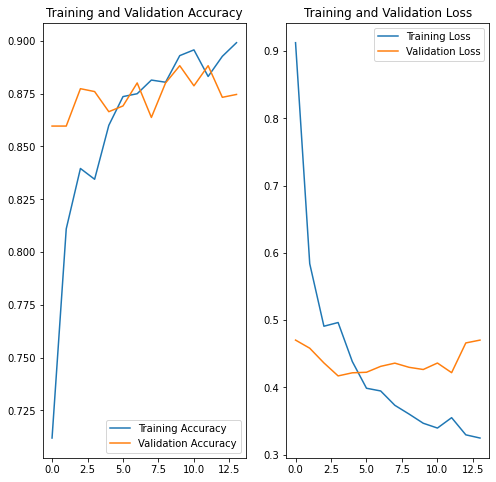

In [36]:
# How many epochs should i ran, until you get the desired/optimal accuracy and loss
# For simplicity i'm gonna go with 50
epochs = 100

# You also specify if there is no improvement in the accuracy/loss you can stop with a callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10) # patience 

history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=epochs, 
                    callbacks=[early_stopping])

def plot_acc_loss(history, epochs_ran):
  # Lets plot the accuracy and loss over epochs
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs_ran)

  # below is matplotlib api's to plot line graph
  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig('H.png')

# Thats it at this point the model is trained
if (early_stopping.stopped_epoch == 0): 
  epochs_ran = epochs
else:
  epochs_ran = early_stopping.stopped_epoch+1 

plot_acc_loss(history, epochs_ran)

### Plot Confusion matrix for validation data

It gives an visual represention of how good the model is performing

Confusion matrix, without normalization


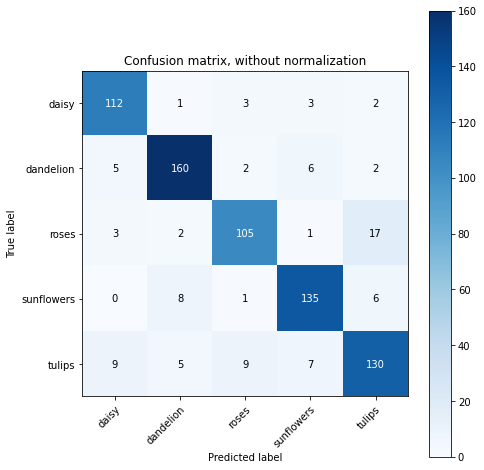

In [37]:
#Defining function for confusion matrix plot - https://analyticsindiamag.com/implementing-efficientnet-a-powerful-convolutional-neural-network/
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

val_ds_u = val_ds.unbatch()
val_ds_u = list(val_ds_u.as_numpy_iterator())
img_arr = np.array([image for image, label in val_ds_u])
lbl_arr = np.array([label for image, label in val_ds_u])

val_p = model.predict(img_arr)


val_r = [np.argmax(y) for y in val_p]


plot_confusion_matrix(val_r, lbl_arr, class_names)

## Step 5: Test the model


In [38]:
# Place an url of any new images and try the results 
image_url = "https://upload.wikimedia.org/wikipedia/commons/c/ce/Daisy_G%C3%A4nsebl%C3%BCmchen_Bellis_perennis_01.jpg"

# tf cahces the data to be dowloaded, so just make sure we clean if any previous image was already stored
!rm datasets/Image.png

# Download the image to local storage
image_path = tf.keras.utils.get_file('Image.png', origin=image_url, cache_dir="./")
# Load the image from local storage using tensorflow api's 
img = tf.keras.preprocessing.image.load_img(
    image_path, 
    target_size=(IMG_WIDTH, IMG_HEIGHT)
    )
img_array = tf.keras.preprocessing.image.img_to_array(img)

img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


print("This definitely an {} - {}".format(class_names[np.argmax(score)], round(100 * np.max(score))))

1261568/1256730 [==============================] - 0s 0us/step
This definitely an daisy - 100
